In [1]:
""" Importing the required libraries and tools """
%matplotlib inline
import tensorflow as tf
import numpy as np  # For working with arrays
from tqdm import tqdm  # Provides pretty graphics when loading data
import matplotlib.pyplot as plt  # For plotting figures
import cv2  # Open-cv for working with images
from IPython.display import clear_output  # Again, for pretty graphics
import os  # For reading files from disk
from random import shuffle, randrange  # For shuffling the data so our model becomes robust, hopefully
import pandas as pd  # For manipulating CSV files
import urllib.request  # For downloading files from the provided links
import time  # Yes, pretty graphics again
from termcolor import colored  # I LOVE COLOURED THINGS

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # For ignoring annoying tensorflow warnings



/home/vipin/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:

""" Defining some required variables """
test_dir = 'Test'
train_dir = 'Train Data'
train_processed = 'Train Processed'
test_processed = 'Test Processed'


batch_size = 125
num_channels = 3
lr = 1e-4
img_size = 256
img_shape = (256, 256)

In [3]:
traincsv = pd.read_csv('myntra_train_dataset.csv')
testcsv = pd.read_csv('myntra_test.csv')

In [4]:
testcsv.head()


,Brand,Category,Gender,Color,Link_to_the_image
0,Allen Solly,Tshirts,Men,Red,http://myntra.myntassets.com/assets/images/182...
1,Celio,Tshirts,Men,Yellow,http://myntra.myntassets.com/assets/images/109...
2,CULT FICTION,Tshirts,Men,Rust,http://myntra.myntassets.com/assets/images/159...
3,Antigravity,Tshirts,Women,Blue,http://myntra.myntassets.com/assets/images/185...
4,Being Human,Tshirts,Men,Charcoal,http://myntra.myntassets.com/assets/images/100...


In [5]:
traincsv.head()  # Just peeking the data

,Brand,Category,Gender,Color,Link_to_the_image,Sub_category
0,Roadster,Tshirts,Men,Black,http://myntra.myntassets.com/assets/images/182...,Graphic
1,Roadster,Tshirts,Men,Black,http://myntra.myntassets.com/assets/images/182...,Graphic
2,Roadster,Tshirts,Men,Black,http://myntra.myntassets.com/assets/images/182...,Biker
3,Roadster,Tshirts,Men,Black,http://myntra.myntassets.com/assets/images/182...,Graphic
4,Roadster,Tshirts,Men,Black,http://myntra.myntassets.com/assets/images/182...,Graphic


In [6]:
print('Train shape: ', traincsv.shape)
print('Test shape: ', testcsv.shape)

Train shape:  (70000, 6)
Test shape:  (15000, 5)


In [7]:
cat = traincsv.select_dtypes(include=['O'])
cat.apply(pd.Series.nunique)  # Looking at all the unique values in the provided dataset

Brand                  378
Category                 1
Gender                   5
Color                   44
Link_to_the_image    68797
Sub_category            24
dtype: int64

In [8]:
traincsv.Sub_category.value_counts()

Solid                     22350
Typography                13114
Striped                    9650
Graphic                    6558
Colourblocked              2542
Abstract                   2303
Geometric                  2062
People and Places          1703
Floral                     1634
Humour and Comic           1515
Conversational             1370
Superhero                  1213
Biker                       671
Sports                      624
Varsity                     608
Sports and Team Jersey      403
Music                       358
Self Design                 332
Tie and Dye                 307
Camouflage                  207
Checked                     196
Tribal                      142
Polka Dots                  137
Horizontal Stripes            1
Name: Sub_category, dtype: int64

In [9]:
sub_category = []
for i in range(traincsv.shape[0]):
    if sub_category.__contains__(str(traincsv.iloc[i]['Sub_category'])):
        pass
    else:
        sub_category.append(str(traincsv.iloc[i]['Sub_category']))
print(len(sub_category), ' sub categories in the given test set are:\n', sub_category) 

24  sub categories in the given test set are:
 ['Graphic', 'Biker', 'Striped', 'Colourblocked', 'Tie and Dye', 'Solid', 'Typography', 'Geometric', 'Camouflage', 'Abstract', 'Tribal', 'People and Places', 'Conversational', 'Sports', 'Floral', 'Humour and Comic', 'Music', 'Checked', 'Self Design', 'Varsity', 'Sports and Team Jersey', 'Polka Dots', 'Superhero', 'Horizontal Stripes']


In [10]:
def transform_image(img, ang_range, shear_range = 0, trans_range = 10):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over.

    A Random uniform distribution is used to generate different parameters for transformation

    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows, cols, ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    # Brightness


    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)

    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    
    return img

In [11]:
def augment_img(sub_category, num_images, num_augmentation = 0):
    i = 70000
    print('Augmenting', sub_category)
    for img in os.listdir(train_dir):
        if sub_category in img:
            if num_images >= num_augmentation:
                break
            path = os.path.join(train_dir, img)
            try:
                img = cv2.imread(path, cv2.IMREAD_COLOR)
                img2 = transform_image(img, ang_range=120)
            except:
                continue
            
            img_name = sub_category+'_'+str(i)+'.jpg'
            cv2.imwrite(img_name, img2)
            os.rename(img_name, train_dir+'/'+img_name)
            i += 1
            num_images += 1
    print('Done!!!')

In [12]:
if False:
    augment_img(sub_category='Striped', num_images=9650, num_augmentation=10000)
    augment_img(sub_category='Graphic', num_images=6558, num_augmentation=10000)
    augment_img(sub_category='Colourblocked', num_images=2542, num_augmentation=5000)
    augment_img(sub_category='Abstract', num_images=2303, num_augmentation=5000)
    augment_img(sub_category='Geometric', num_images=2062, num_augmentation=5000)

In [13]:
def one_hot(i):
    a = np.zeros(24, dtype='uint8')
    a[i] = 1
    return a

In [14]:
""" Here we will create one-hot encoded labels for the testing data provided to us """


def create_labels(img):
    img_name = img.split('_')[0]
    for i in range(len(sub_category)):
        if img_name == sub_category[i]:
            return one_hot(i)

In [15]:
def create_training_data(batch_size):
    print('Creating training data')
    if(not os.path.exists(train_processed)):
        os.mkdir(train_processed)
    j = i = 1
    training_data = []
    imglist = []
    for img in os.listdir(train_dir):
        imglist.append(img)
    shuffle(imglist)
    for k in tqdm(range(len(imglist))):
        img = imglist[randrange(0, len(imglist))]
        path_img = os.path.join(train_dir, img)
        try:
            img_data = cv2.imread(path_img, cv2.IMREAD_COLOR)
            img_data = cv2.resize(img_data, img_shape)
            training_data.append([np.array(img_data), np.array(create_labels(img))])
            j += 1
        except:
            pass
        if j==batch_size:
            shuffle(training_data)
            np.save('batch'+str(i)+'.npy', training_data)
            os.rename('batch'+str(i)+'.npy', train_processed+'/batch'+str(i)+'.npy')
            j = 1
            i += 1
            training_data = []
    print('Training data created\n')

In [16]:
# If running model for the first time or if you are changing the batch size
if False:
    create_training_data(batch_size)

In [17]:
tf.reset_default_graph()

In [18]:
""" Some neural net related variables """


n_classes = len(sub_category)
x = tf.placeholder('float', [None, img_size, img_size, num_channels])  # Will hold the images
y = tf.placeholder('float',[None, n_classes])  # Will hold the labels

    
initializer = tf.contrib.layers.xavier_initializer()
    
weights = {'W_conv1': tf.Variable(initializer([5, 5, 3, 16])),
               'W_conv2': tf.Variable(initializer([5, 5, 16, 32])),
               'W_conv3': tf.Variable(initializer([5, 5, 32, 64])),
               'W_conv4': tf.Variable(initializer([5, 5, 64, 32])),
               'W_fc1': tf.Variable(initializer([16*16*32, 1024])),
               'W_fc2': tf.Variable(initializer([1024, 512])),
               'W_fc3': tf.Variable(initializer([512, 128])),
               'out': tf.Variable(initializer([128, n_classes]))}
    
    
biases = {'b_conv1': tf.Variable(tf.random_normal([16])),
               'b_conv2': tf.Variable(tf.random_normal([32])),
               'b_conv3': tf.Variable(tf.random_normal([64])),
               'b_conv4': tf.Variable(tf.random_normal([32])),
               'b_fc1': tf.Variable(tf.random_normal([1024])),
               'b_fc2': tf.Variable(tf.random_normal([512])),
               'b_fc3': tf.Variable(tf.random_normal([128])),
               'out': tf.Variable(tf.random_normal([n_classes]))}


# Train data is from batch 1 to batch 300
# Validation data is from batch 300 to 305
# All the remaining data will be used for testing

In [19]:
""" Here we will design our convolutional neural network by using the layers provided in 
    tf.layers"""

def CNN(x):

    
    
    """ The image will be feeded to input layer """
    x = tf.image.convert_image_dtype(x, dtype=tf.float32)
    
    input_layer = tf.reshape(x, [-1, img_size, img_size, num_channels])
    
    
    """ First convolutional layer with 64 filters of 256x256 dimentions, followed by relu & 2x2 maxpool layer """
    
    conv1 = tf.nn.relu(tf.add(tf.nn.conv2d(input_layer, weights['W_conv1'], strides=[1, 1, 1, 1], padding='SAME', 
                                           name='conv1'), biases['b_conv1']))
    
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    
    """ Second convolutional layer with 128 filters of 128x128 dimentions, followed by relu & 2x2 maxpool layer """
    
    conv2 = tf.nn.relu(tf.add(tf.nn.conv2d(pool1, weights['W_conv2'], strides=[1, 1, 1, 1], padding='SAME', 
                                          name='conv2'), biases['b_conv2']))
    
    pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    
    """ Third convolutional layer with 128 filters of 64x64 dimentions, followed by relu & 2x2 maxpool layer """
    
    conv3 = tf.nn.relu(tf.add(tf.nn.conv2d(pool2, weights['W_conv3'], strides=[1, 1, 1, 1], padding='SAME', 
                                          name='conv3'), biases['b_conv3']))
    
    pool3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    
    """ Fourth convolutional layer with 64 filters of 32x32 dimentions, followed by replu & 2x2 maxpool layer """
    
    conv4 = tf.nn.relu(tf.add(tf.nn.conv2d(pool3, weights['W_conv4'], strides=[1, 1, 1, 1], padding='SAME', 
                                      name='conv4'), biases['b_conv4']))
    
    pool4 = tf.nn.max_pool(conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    
    dropout = tf.nn.dropout(pool4, keep_prob=0.4)
    
    """ A fully connected layers """
    
    fully_connected = tf.reshape(dropout, [-1, 16*16*32]) # This will work as flattening layer
    fully_connected = tf.nn.relu(tf.add(tf.matmul(fully_connected, weights['W_fc1']), biases['b_fc1'])) 
    fully_connected = tf.nn.relu(tf.add(tf.matmul(fully_connected, weights['W_fc2']), biases['b_fc2']))
    fully_connected = tf.nn.relu(tf.add(tf.matmul(fully_connected, weights['W_fc3']), biases['b_fc3']))
    
    """ Dropout layer to prevent over-fitting """
    dropout = tf.nn.dropout(fully_connected, keep_prob=0.6)
    
    
    """ Output Layer """
    
    out = tf.add(tf.matmul(dropout, weights['out']), biases['out']) # This is also know as logits layer
    return out

In [20]:
def load_batch(i):
    os.rename(train_processed+'/batch'+str(i+1)+'.npy', 'batch'+str(i+1)+'.npy')
    batch = np.load('batch'+str(i+1)+'.npy')
    x = np.array([j[0] for j in batch]).reshape(-1, img_size, img_size, num_channels)
    y = [j[1] for j in batch]
    os.rename('batch'+str(i+1)+'.npy', train_processed+'/batch'+str(i+1)+'.npy')
    return x, y

In [21]:
""" This is the function that will be used for training the neural network"""

def train_neural_network(x):
    

    prediction = CNN(x)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=prediction, labels=y))
    y_pred_cls = tf.nn.softmax(prediction)

    # Default learning rate to AdamOptimizer is 0.001 so we are not providing any as we'll be using that only
    optimizer = tf.train.AdamOptimizer(lr).minimize(cost)
    best_val = 0
    val_acc = 0
    # epochs is one whole cycle of feedforward and backprop though out the whole dataset
    num_epochs = 10
    
    # For saving the variables 
    saver = tf.train.Saver()
    
    
    with tf.Session() as sess:
        
        if os.path.exists('tmp/Model1/model1.ckpt.index'):
            print('Restoring Model......')
            saver.restore(sess, 'tmp/Model1/model1.ckpt')
            print('Model Restored')
            correct = tf.equal(tf.argmax(y_pred_cls, 1), tf.argmax(y, 1))  # 1 represents the axis
            accuracy = tf.reduce_mean(tf.cast(correct, 'float32'))
            for i in range(620, 640):
                x_val, y_val = load_batch(i)
                val_acc += accuracy.eval({x: x_val, y: y_val})
            best_val = val_acc/20
            print('Current saved model\'s validation accuracy is:', "%.4f" % best_val)
        #filewriter = tf.summary.FileWriter('./tmp/log', sess.graph)
        
        else:
            sess.run(tf.global_variables_initializer())

        for epochs in range(num_epochs):

            start_time = time.time()
            epoch_loss = 0
            for w in range(620):
                batch_x, batch_y = load_batch(w)
                try:
                    _ , c = sess.run([optimizer, cost], feed_dict={x: batch_x, y: batch_y})
                except:
                    continue
                epoch_loss += c
                correct = tf.equal(tf.argmax(y_pred_cls, 1), tf.argmax(y, 1))  # 1 represents the axis
                accuracy = tf.reduce_mean(tf.cast(correct, 'float32'))
                acc = accuracy.eval({x: batch_x, y: batch_y})

                clear_output(wait=True)
                print('Epoch:', epochs+1, '|', 'Loss:', colored( "%.4f" % c, 'red'), '|', 'Train Accuracy', 
                      colored("%.4f" % acc, 'green'), '|', w+1, 'out of', 620, ' iterations done')
                
                
            end_time = time.time()
            correct = tf.equal(tf.argmax(y_pred_cls, 1), tf.argmax(y, 1))  # 1 represents the axis
            accuracy = tf.reduce_mean(tf.cast(correct, 'float32'))
            val_acc = 0
            for i in range(620, 640):
                x_val, y_val = load_batch(i)
                val_acc += accuracy.eval({x: x_val, y: y_val})
            val_acc = val_acc/20
            
            print('Epoch', epochs+1, 'completed out of', num_epochs, '|', 'Epoch Loss:', 
                  colored("%.4f" % epoch_loss, 'red') , '|', 'Validation Accuracy', 
                  colored("%.4f" % val_acc, 'green'), '|', 'Time taken:', end_time-start_time)
            
            if val_acc>best_val:
                save_path = saver.save(sess, "tmp/Model1/model1.ckpt")
                print("Model saved in path: %s" % save_path)
                best_val = val_acc
                
            print('Current saved model\'s validation accuracy is:', "%.4f" % best_val)
            
    

In [22]:
if False:
    train_neural_network(x)

Test Accuracy:  0.8280
X-axis is Predicted label
Y-axis is True label


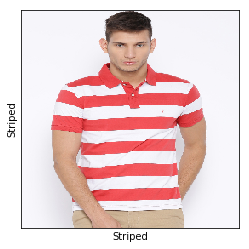

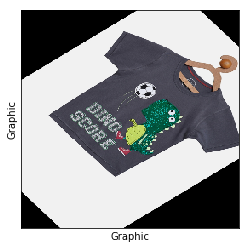

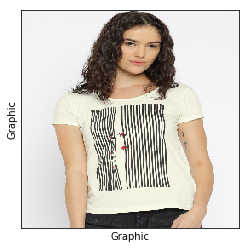

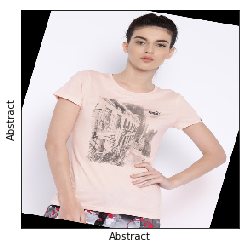

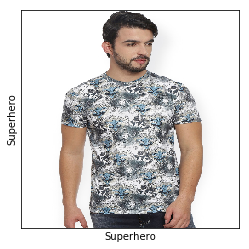

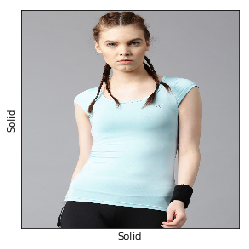

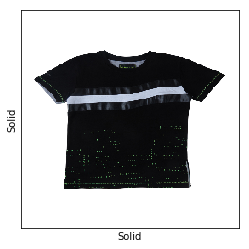

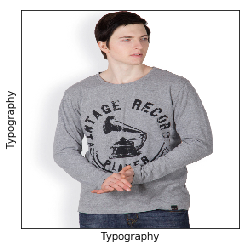

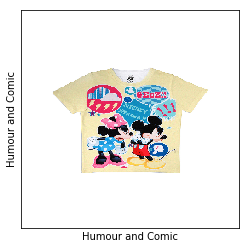

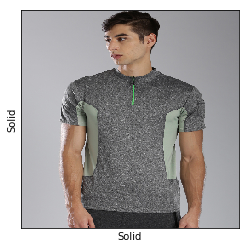

In [23]:
saver = tf.train.Saver()
with tf.Session() as sess:
    
    #sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'tmp/Model1/model1.ckpt')
    accu = 0
    
    prediction = CNN(x)
    y_pred_cls = tf.argmax(tf.nn.softmax(prediction), 1)
    y_true_cls = tf.argmax(y, 1)
    correct = tf.equal(y_pred_cls, y_true_cls)  # 1 represents the axis
    accuracy = tf.reduce_mean(tf.cast(correct, 'float32'))
    
        
    
    for i in range(640, 643):
        x_test, y_test = load_batch(i)
        accu += accuracy.eval({x: x_test, y: y_test})
    accu = accu/3
        
    print('Test Accuracy: ', "%.4f" % accu)
    
    print('X-axis is Predicted label\nY-axis is True label')
    for i in range(70, 80):
            img = x_test[i].reshape(img_size, img_size, 3)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.ylabel(sub_category[y_true_cls[i].eval({x: x_test, y: y_test})])
            plt.xlabel(sub_category[y_pred_cls[i].eval({x: x_test, y: y_test})])
            plt.xticks([], [])
            plt.yticks([], [])
            plt.show()


    